In [1]:
import os
#load from json .creds/PINECONE_API
import json
with open('.creds/PINECONE_API') as f:
    creds = json.load(f)
    PINECONE_API_KEY = creds['PINECONE_API_KEY']
    PINECONE_ENVIRONMENT = creds['PINECONE_ENVIRONMENT']
    OPENAI_API_KEY = creds['OPENAI_API_KEY']

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# MVP: Mindfinder

We are going to have in the metadata constrains values such as location, age, tastes, etc and in the representation of the person we are going to have all the data from social networks.

## MVP


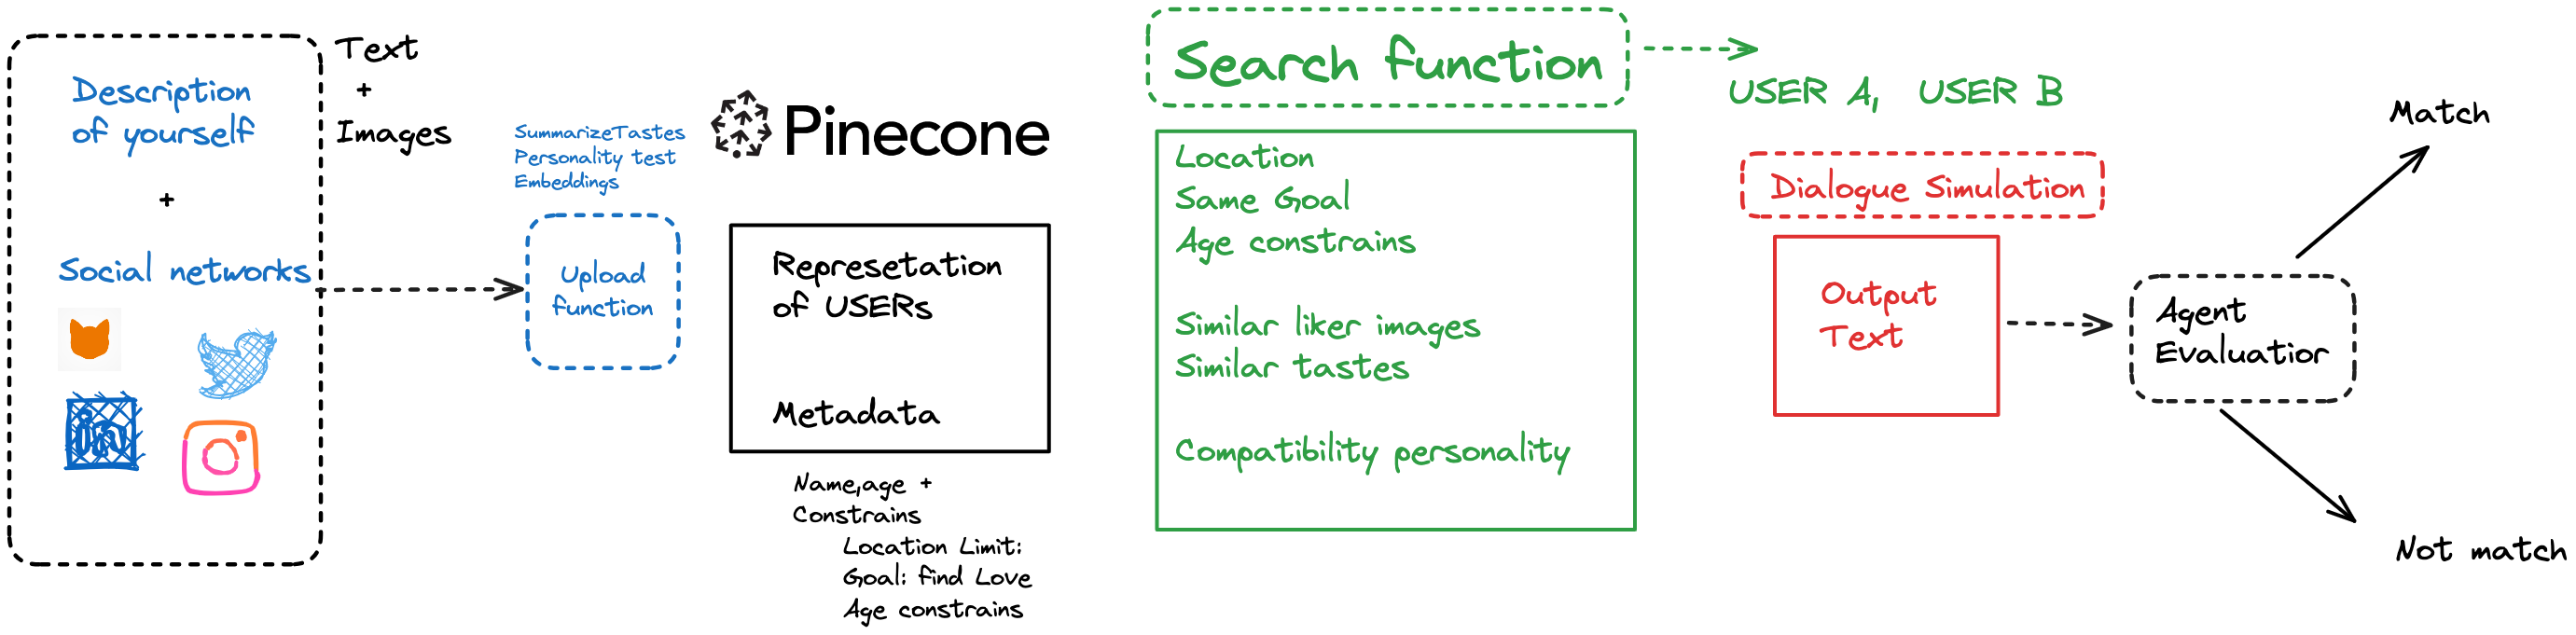

In [2]:
from IPython.display import Image
Image(filename='figs/workflow_mvp.png', width=500)

## TO-DO:
1. From social networks + imagen + text -> Representation of the person
2. From the representation of the person -> Metadata
3. Pinecone Database with all the users

In [3]:
#to autoreload jupyter packagfes
%load_ext autoreload
%autoreload 2
%autosave 60

Autosaving every 60 seconds


# 4. Similarity Search

So I create a mock of a function that creates the first filter

In [4]:
from src.mock_database import pinecone_example, similarity_search
user_a, user_b = similarity_search(pinecone_example)


In [5]:
print("User A:", user_a['name'])
print("User B:", user_b['name'])

User A: John Sullivan
User B: Mary Smith


# 5. Dialogue Simulation

Conversación entre dos agentes. In this notebook, we show how we can use concepts from [CAMEL](https://www.camel-ai.org/) para simular una conversación entre una posible pareja.To simulate this game, we create an `DialogueSimulator` class that coordinates the dialogue between the two agents.

In [6]:
from typing import List, Dict, Callable
from langchain.chat_models import ChatOpenAI
from langchain.schema import (
    HumanMessage,
    SystemMessage,
)

In [7]:
from src.agent_type import DialogueAgent
from src.simulation_type import DialogueSimulator

## Quest--> Define Conditions of the Dialogue

In [8]:
word_limit = 50  # word limit for task brainstorming
quest = "Find your things in common and the things you not agree. Decide if you can be lovers."

### Roles of Users

In [9]:
userA_system_message = SystemMessage(
    content=(
        f"""{quest}
Never forget you are looking for a match, trying to find of the person in front of you is suitable for you. You are {user_a['name']}, and your date is {user_b['name']}.
Your character description is as follows: {user_a['description']}.
You will propose actions you plan to take, you will talk about yourself and what you look, your are going to ask questions to the your date {user_b['name']} .
Speak in the first person from the perspective of {user_a['name']}.
For describing your own body movements, wrap your description in '*'.
Do not change roles!
Do not speak from the perspective of  {user_b['name']}.
Do not forget to finish speaking by saying, 'It is your turn, {user_b['name']}.'
Do not add anything else.
Remember you are the protagonist, {user_a['name']}.
Stop speaking the moment you finish speaking from your perspective.
"""
    )
)

userB_system_message = SystemMessage(
    content=(
        f"""{quest}
Never forget you are looking for a match, trying to find of the person in front of you is suitable for you. You are {user_b['name']}, and your date is {user_a['name']}.
Your character description is as follows: {user_b['description']}.
You will propose actions you plan to take, you will talk about yourself and what you look, your are going to ask questions to the your date {user_a['name']} .
Speak in the first person from the perspective of {user_b['name']}.
For describing your own body movements, wrap your description in '*'.
Do not change roles!
Do not speak from the perspective of  {user_a['name']}.
Do not forget to finish speaking by saying, 'It is your turn, {user_a['name']}.'
Do not add anything else.
Remember you are the protagonist, {user_b['name']}.
Stop speaking the moment you finish speaking from your perspective.
"""
    )
)


## Use an LLM to create an elaborate quest description

In [10]:
quest_specifier_prompt = [
    SystemMessage(content="You can make a task more specific."),
    HumanMessage(
        content=f"""{quest}
        
        You are in date {user_a["name"]} and {user_b["name"]}, both be respectfull, care to know each other, find out common tastes and posible plans or conflicts.
         Be creative and imaginative.
        Please reply with the specified quest in {word_limit} words or less. 
        Speak directly to the echa other .
        Do not add anything else."""
    ),
]
specified_quest = ChatOpenAI(temperature=1.0)(quest_specifier_prompt).content

print(f"Original quest:\n{quest}\n")
print(f"Detailed quest:\n{specified_quest}\n")

Original quest:
Find your things in common and the things you not agree. Decide if you can be lovers.

Detailed quest:
John, let's discuss our interests and hobbies. Do you enjoy hiking or going to the beach? I love trying new restaurants and going to concerts. On the other hand, Mary, I noticed we have different political views, can we talk about this and see if we can respectfully disagree without it being an issue for us as a couple?



## Main Loop

In [11]:
protagonist = DialogueAgent(
    name=user_a['name'],
    system_message=userA_system_message,
    model=ChatOpenAI(temperature=0.2),
)
storyteller = DialogueAgent(
    name=user_b['name'],
    system_message=userB_system_message,
    model=ChatOpenAI(temperature=0.2),
)

In [12]:
def select_next_speaker(step: int, agents: List[DialogueAgent]) -> int:
    idx = step % len(agents)
    return idx

In [14]:
max_iters = 6
n = 0

simulator = DialogueSimulator(
    agents=[storyteller, protagonist], selection_function=select_next_speaker
)
simulator.reset()
simulator.inject(user_a["name"], specified_quest)
print(f"({user_b['name']}): {specified_quest}")
print("\n")

while n < max_iters:
    name, message = simulator.step()
    print(f"({name}): {message}")
    print("\n")
    n += 1

(Mary Smith): John, let's discuss our interests and hobbies. Do you enjoy hiking or going to the beach? I love trying new restaurants and going to concerts. On the other hand, Mary, I noticed we have different political views, can we talk about this and see if we can respectfully disagree without it being an issue for us as a couple?


(John Sullivan): I also love hiking and exploring new trails. It's a great way to stay active and enjoy nature. As for our political views, I think it's important to have open and respectful discussions about our differences. It's okay to not agree on everything, as long as we can still respect each other's opinions and beliefs. What are some of your favorite hobbies and interests, Mary? It is your turn, Mary Smith.


(Mary Smith): Hi John, I completely agree with you about having open and respectful discussions about our differences. It's important to be able to communicate and understand each other's perspectives. As for my hobbies and interests, I hav